# Loki Decompose - CRC Sample

This notebook demonstrates how to run *Loki Decompose* on a dataset of colorectal cancer sample. It takes about 2 mins to run this notebook on MacBook Pro.

In [1]:
import scanpy as sc
import torch
import numpy as np  
import pandas as pd
import os 
from matplotlib import pyplot as plt
import matplotlib

import loki.decompose
# set resolution to 80 dpi for showing in the notebook
# matplotlib.rcParams['figure.dpi'] = 80
sc.set_figure_params(dpi=80, facecolor='white', frameon=False, color_map='viridis')

We first finetune OmiCLIP model on the Visium colorectal cancer data.

In [2]:
%%script echo "Comment this line to fine-tune the model on the CRC dataset."

import subprocess
import open_clip

model_name='coca_ViT-L-14'
pretrained_weight_path='path to the omiclip pretrained weight'
train_csv = 'visium_data/finetune_data.csv'
name = 'finetune_crc'

train_command = [
    'python', '-m', 'training.main',
    '--name', name,
    '--save-frequency', '5',
    '--zeroshot-frequency', '10',
    '--report-to', 'wandb',
    '--train-data', train_csv,
    '--csv-img-key', 'img_path',
    '--csv-caption-key', 'label',
    '--warmup', '10',
    '--batch-size', '64',
    '--lr', '5e-6',
    '--wd', '0.1',
    '--epochs', '5',
    '--workers', '16',
    '--model', model_name,
    '--csv-separator', ',',
    '--pretrained', pretrained_weight_path,
    '--lock-text-freeze-layer-norm',
    '--lock-image-freeze-bn-stats',
    '--coca-caption-loss-weight','0',
    '--coca-contrastive-loss-weight','1',
    '--val-frequency', '10',
    '--aug-cfg', 'color_jitter=(0.32, 0.32, 0.32, 0.08)', 'color_jitter_prob=0.5', 'gray_scale_prob=0'
]

subprocess.run(train_command)

Comment this line to fine-tune the model on the CRC dataset.


We provide the embeddings generated from the OmiCLIP model.
The sample data and embeddings are stored in the directory `data/loki_decompose/CRC_data`, which can be donwloaded from [Google Drive link](https://drive.google.com/file/d/1aPK1nItsOEPxTihUAKMig-vLY-DMMIce/view?usp=sharing).

Here is a list of the files that are needed to run the cell type decomposition on the pseudo Visium data:
```
    .                                                                                                                       
    ├── checkpoint_finetune_crc                                                                                                 
    │   ├── sc_text_emb.pt                                                                                           
    │   ├── val_data_all_val_img_emb.pt                                                                              
    │   ├── val_data_val_img_emb.pt                                                                                  
    │   └── val_data_val_txt_emb.pt                                                                                  
    ├── scRNA_data                                                                                                          
    │   └── sc_CRC2_labels.csv                                                                                                                           
    └── pseudo_visium_data                                                                                                     
        ├── val_data_all.csv  (# meta data for embedding extraction from the entire slide)                                                                                              
        ├── val_data.csv (# meta data for embedding extraction from the Visium capture region)     
        ├── cell_centroids.npy                                                                                              
        └── Visium_HD_Human_Colon_Cancer_P2_8bin_simulated_100_55_processed.h5ad                                            
```

In [3]:
data_dir = "./data/loki_decompose/CRC_data/pseudo_visium_data"
checkpoint_name = "finetune_crc"
embedding_dir = f"./data/loki_decompose/CRC_data/checkpoint_{checkpoint_name}"
cell_adata_labels_path = "./data/loki_decompose/CRC_data/scRNA_data/sc_CRC2_labels.csv"

fig_dir = f"{checkpoint_name}_figures"
os.makedirs(fig_dir, exist_ok=True)

In [4]:
# The spatial coordinates and the HE image from the spot data were used to visualize the predcition results.
spot_adata_path = f"{data_dir}/Visium_HD_Human_Colon_Cancer_P2_8bin_simulated_100_55_processed.h5ad"
spot_adata = sc.read_h5ad(spot_adata_path)
spot_adata

AnnData object with n_obs × n_vars = 3593 × 18085
    obs: 'DeconvolutionLabel1', 'nonEmptySpots', 'n_counts', 'leiden', 'B cells', 'Endothelial', 'Fibroblast', 'Intestinal Epithelial', 'Myeloid', 'Neuronal', 'Smooth Muscle', 'T cells', 'Tumor', 'Unknown'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Celltype_colors', 'DeconvolutionLabel1_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'mapping', 'neighbors', 'pca', 'spatial'
    obsm: 'X_pca', 'deconvolution', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

Load pre-computed spot image embeddings

In [5]:
spot_im_embedding_path = f'{embedding_dir}/val_data_val_img_emb.pt'
spot_im_embedding = torch.load(spot_im_embedding_path)
spot_im_embedding.shape

torch.Size([3593, 768])

Load pre-computed spot ST embeddings

In [6]:
spot_tx_embedding_path = f'{embedding_dir}/val_data_val_txt_emb.pt'
spot_tx_embedding = torch.load(spot_tx_embedding_path)
spot_tx_embedding.shape

torch.Size([3593, 768])

Load pre-computed single-cell RNA-seq embeddings

In [7]:
cell_embedding_path =f"{embedding_dir}/sc_text_emb.pt"
cell_embedding = torch.load(cell_embedding_path)
cell_embedding.shape

torch.Size([35695, 768])

In [8]:
cell_adata_labels = pd.read_csv(cell_adata_labels_path, index_col=0)
cell_adata_em = sc.AnnData(X=cell_embedding.numpy(), obs=cell_adata_labels)
cell_adata_em.obs

Level1
AAACAAGCAACAGCTAACTTTAGG-1        B cells
AAACAAGCAACTGTTCACTTTAGG-1        T cells
AAACAAGCAAGGCCTGACTTTAGG-1          Tumor
AAACAAGCACATAGTGACTTTAGG-1          Tumor
AAACAAGCAGCATTTCACTTTAGG-1        Myeloid
...                                   ...
TTTGGCGGTGGCGTAGACTTTAGG-7        B cells
TTTGGCGGTTAGTGCTACTTTAGG-7  Smooth Muscle
TTTGTGAGTCCGCTAAACTTTAGG-7          Tumor
TTTGTGAGTCCGGGTTACTTTAGG-7        Myeloid
TTTGTGAGTCTTTATCACTTTAGG-7          Tumor

[35695 rows x 1 columns]

## Loki Decompose on ST data
Run cell type decomposition using the ST data.

In [9]:
major_types = ['Tumor', 'Fibroblast', 'Smooth Muscle', 'Intestinal Epithelial']
cell_embedding.shape, spot_tx_embedding.shape, spot_im_embedding.shape

(torch.Size([35695, 768]), torch.Size([3593, 768]), torch.Size([3593, 768]))

In [10]:
spot_adata_tx_em = sc.AnnData(X=spot_tx_embedding.numpy())
spot_adata_tx_em.obsm['spatial'] = spot_adata.obsm['spatial']
spot_adata_tx_em.uns['spatial'] = spot_adata.uns['spatial']
cell_adata = cell_adata_em.copy()

In [11]:
%%capture
spot_adata_tx_em = loki.decompose.cell_type_decompose(cell_adata, spot_adata_tx_em, cell_type_col='Level1', NMS_mode=True, major_types=major_types)

In [12]:
df = spot_adata_tx_em.obsm['tangram_ct_pred']
spot_adata_tx_em.obs[df.columns] = df

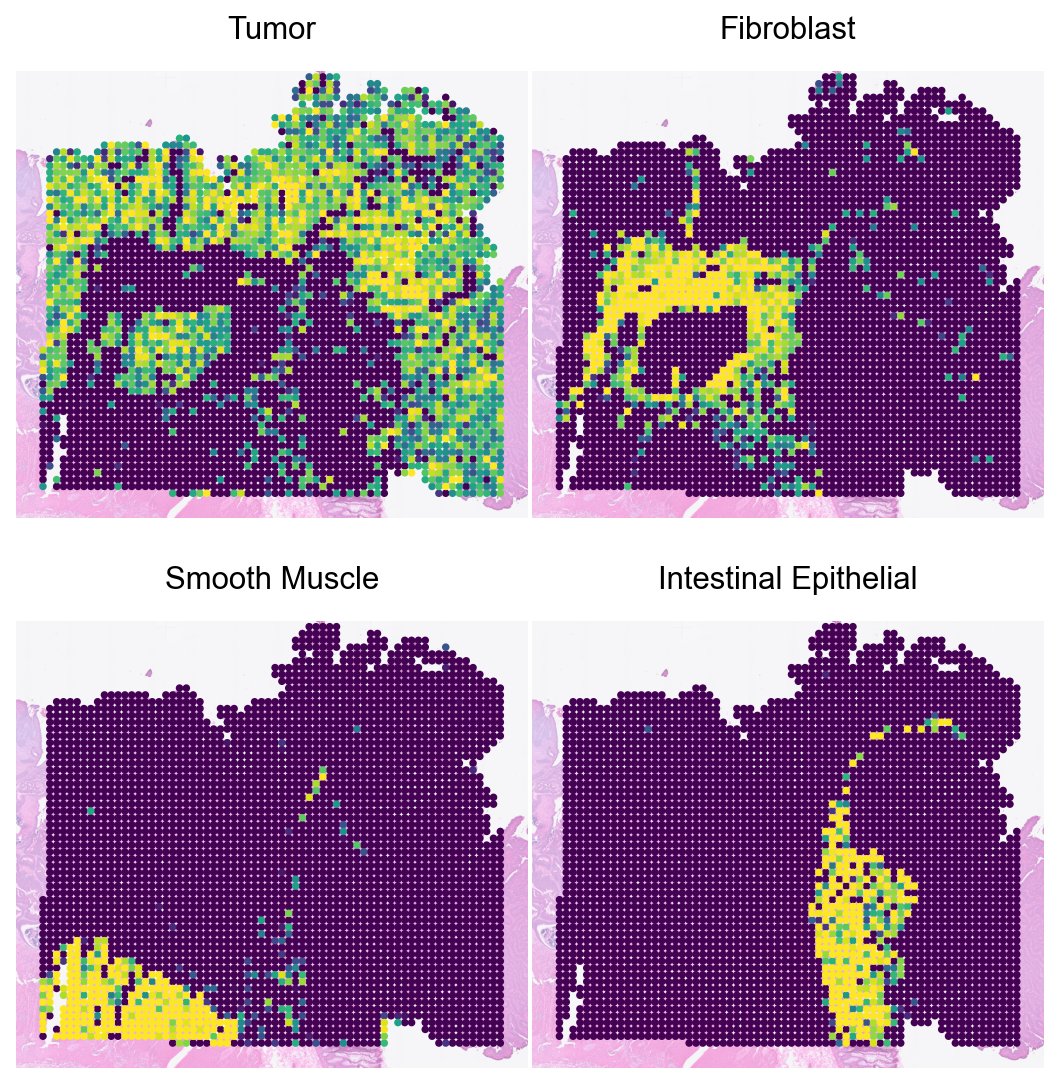

In [13]:
sc.pl.spatial(spot_adata_tx_em, color=major_types, size=2, vmax='p99', cmap='viridis', frameon=False, alpha_img=0.5, colorbar_loc=None, show=False, ncols=2, wspace=0.01, hspace=0.1)
plt.show()

## Loki Decompose on image
Run cell type decomposition using the image.

In [14]:
spot_adata_im_em = sc.AnnData(X=spot_im_embedding.numpy())
spot_adata_im_em.obsm['spatial'] = spot_adata.obsm['spatial']
spot_adata_im_em.uns['spatial'] = spot_adata.uns['spatial']
cell_adata = cell_adata_em.copy()

In [15]:
%%capture
spot_adata_im_em = loki.decompose.cell_type_decompose(cell_adata, spot_adata_im_em, cell_type_col='Level1', NMS_mode=True, major_types=major_types)

In [16]:
df = spot_adata_im_em.obsm['tangram_ct_pred']
spot_adata_im_em.obs[df.columns] = df

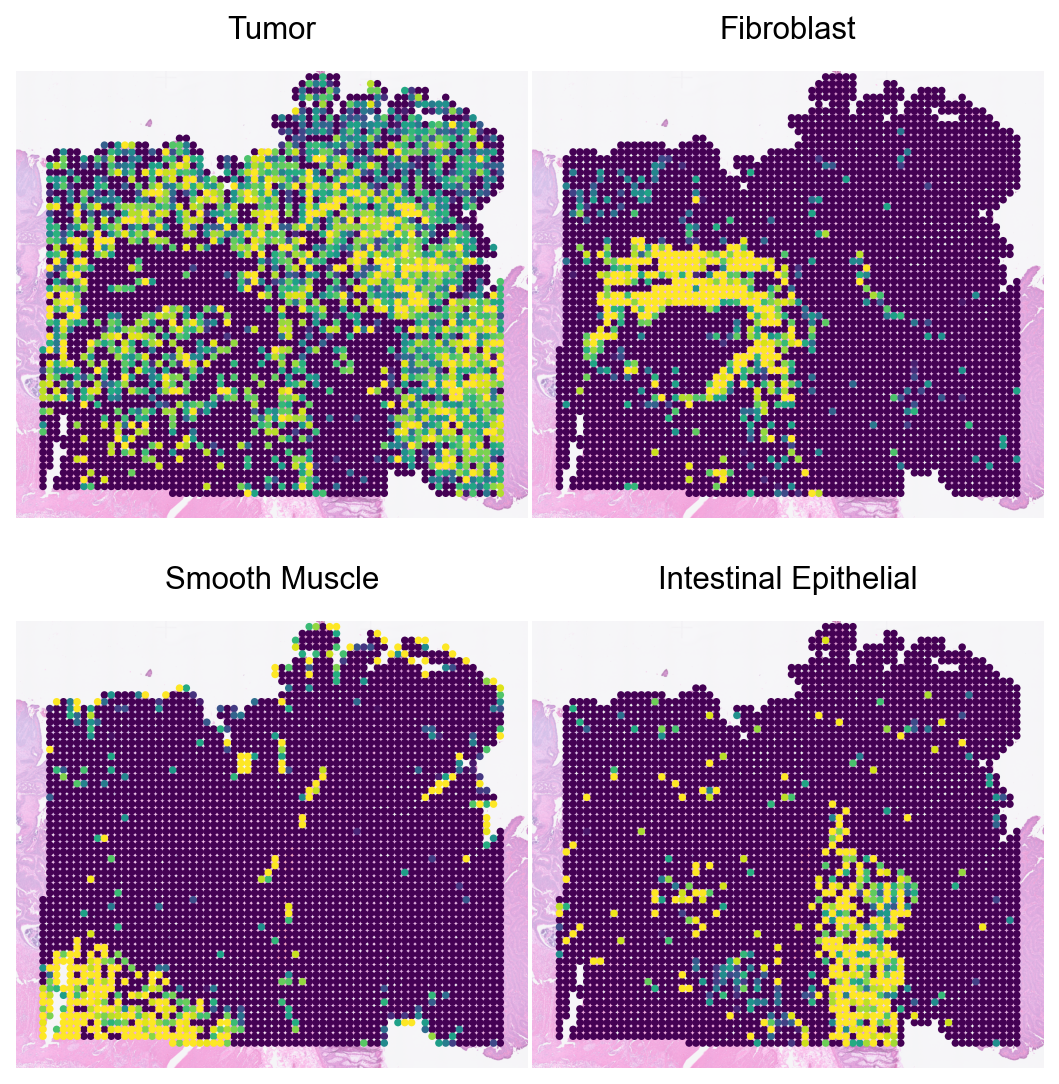

In [17]:
sc.pl.spatial(spot_adata_im_em, color=major_types, size=2, vmax='p99', cmap='viridis', frameon=False, alpha_img=0.5, colorbar_loc=None, show=False, ncols=2, wspace=0.01, hspace=0.1)
plt.show()

## Loki Decompose on whole-slide-image (WSI)
The image is about 20 mm x 13 mm. We use a sliding window of 0.1 mm x 0.1 mm to decompose the cell types in the entire image. 

To be consistent with the workflow in Loki, we first create image patches ("spots") and saved the image patches to disk. 

We then encode the image patches using the fine-tuned OmiCLIP model. 

Finally, we use the encoded image patches to decompose the cell types in the entire image.

### Cell type decompoistion on WSI
Run cell type decomposition using the WSI.

In [18]:
spot_im_embedding_path = f'{embedding_dir}/val_data_all_val_img_emb.pt'
spot_im_embedding = torch.load(spot_im_embedding_path)
spot_locs = pd.read_csv(f'{data_dir}/val_data_all.csv', usecols=['x', 'y'])

# the coordinates were in pixels of the hires image
# notice the patch size is 16x16 and I use the top-left corner of the patch as the location of the cell
# use the center of the patch as the location of the spot instead
spot_locs = spot_locs + 8
spot_locs = pd.read_csv(f'{data_dir}/val_data_all.csv', usecols=['x', 'y'])
scalf = spot_adata.uns['spatial']['Visium_HD_Human_Colon_Cancer_P2']['scalefactors']['tissue_hires_scalef']
ad_all_spot = sc.AnnData(X=spot_im_embedding.numpy())
ad_all_spot.obsm['spatial'] = spot_locs.values / scalf
ad_all_spot.uns['spatial'] = spot_adata.uns['spatial']

cell_adata = cell_adata_em.copy()

In [19]:
cell_type_fractions = cell_adata.obs['Level1'].value_counts() / cell_adata.n_obs
cell_coords_file = f"{data_dir}/cell_centroids.npy"
cell_coords = np.load(cell_coords_file)
cell_to_spot = loki.decompose.assign_cells_to_spots(cell_coords*scalf, ad_all_spot.obsm['spatial']*scalf, patch_size=16)
n_cells_in_spot = cell_to_spot.sum(axis=0).A1

In [20]:
%%capture
ad_all_spot = loki.decompose.cell_type_decompose(cell_adata, ad_all_spot, cell_type_col='Level1')

In [21]:
df = ad_all_spot.obsm['tangram_ct_pred']
ad_all_spot.obs[df.columns] = df

fractions = df * cell_type_fractions
fractions = fractions.div(fractions.sum(axis=1), axis=0)
cell_numbers = fractions * n_cells_in_spot.reshape(-1, 1)
ad_all_spot.obs[[f'{col}_cells' for col in df.columns]] = cell_numbers

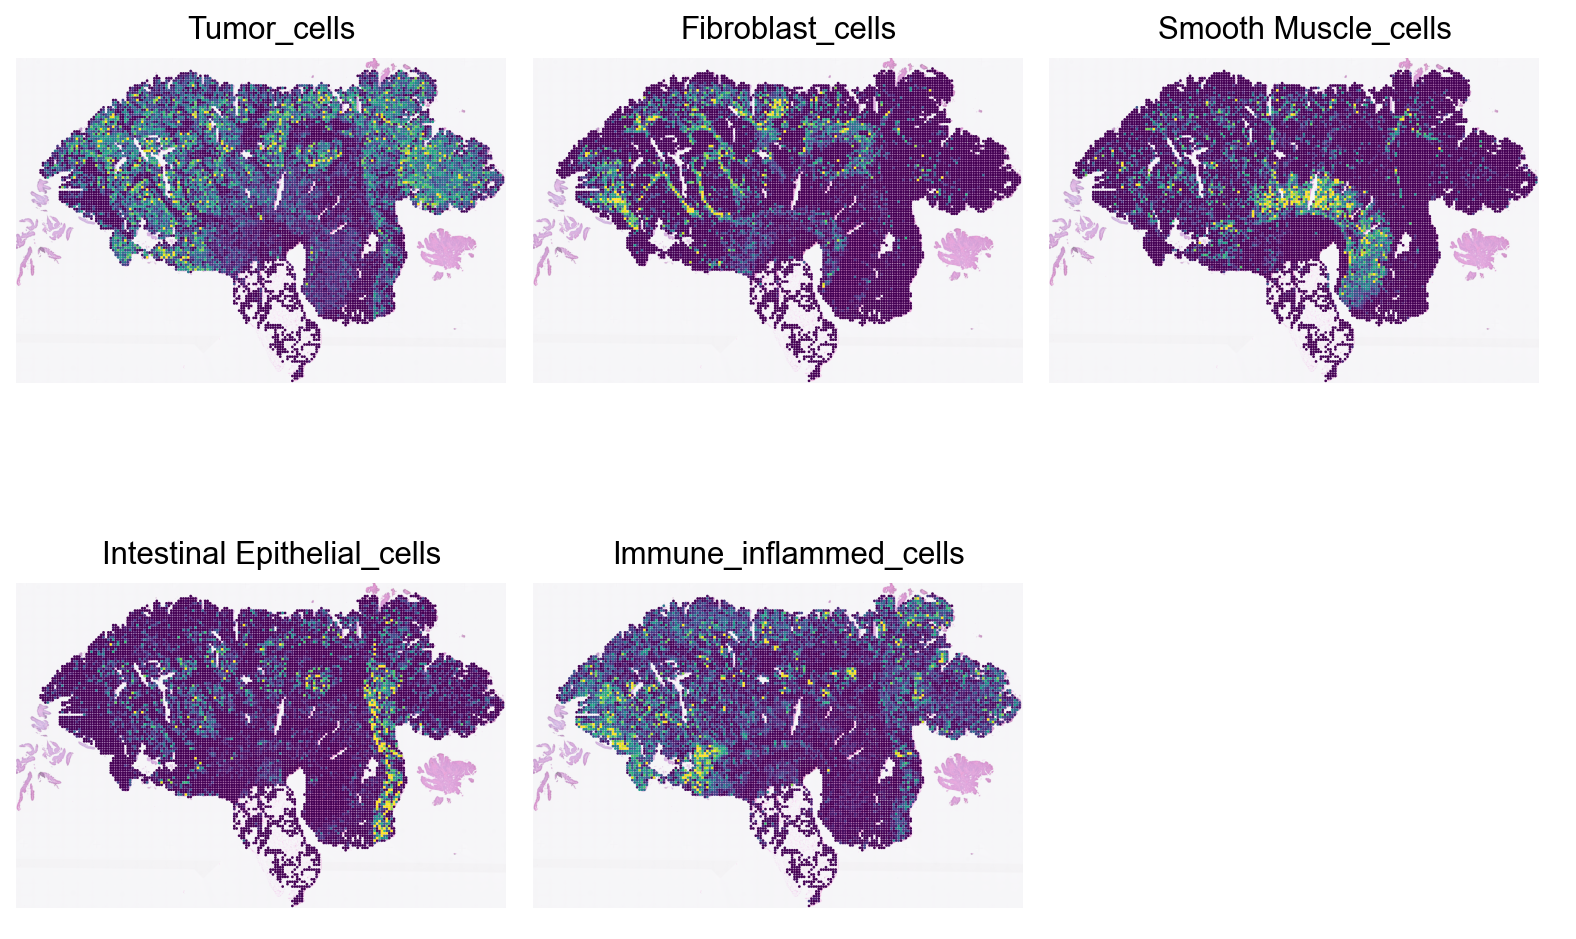

In [22]:
types_from_pathology = ['Tumor', 'Fibroblast', 'Smooth Muscle', 'Intestinal Epithelial', 'Immune_inflammed']
# add immune inflamed cells from the three cell types in the group
immune_inflamed_group = ['T cells', 'B cells', 'Myeloid']
ad_all_spot.obs['Immune_inflammed_cells'] = ad_all_spot.obs[[f'{col}_cells' for col in immune_inflamed_group]].sum(axis=1)

sc.pl.spatial(ad_all_spot, color=[f"{type}_cells" for type in types_from_pathology], size=2, vmax='p99', cmap='viridis', frameon=False, alpha_img=0.5, colorbar_loc=None, show=False, ncols=3, wspace=0.01, hspace=0.001)
plt.show()